## 4.1 Evaluation metrics: session overview

_Metric_ - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/refs/heads/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.columns = df.columns.str.lower().str.replace(" ", "_")
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')


df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state=1)

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']


In [6]:
dv = DictVectorizer(sparse=False)

train_dicts=df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(max_iter=2020)
model.fit(X_train, y_train)

/home/alex/python_projects/machine-learning-zoomcamp-homework/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=2020)

In [7]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).sum()

np.int64(1132)

In [10]:
#Accuracy (in this case is the same as mean) 
1132/1409

0.8034066713981547

In [11]:
#we can move our threshold

threshholds = np.linspace(0, 1, 21)
scores = []

for t in threshholds:
    churn_decision = (y_pred >=t)
    score = (y_val == churn_decision).mean()
    scores.append(score)
    print("%.2f  %.3f" % (t, score))

0.00  0.274
0.05  0.513
0.10  0.608
0.15  0.662
0.20  0.703
0.25  0.735
0.30  0.758
0.35  0.764
0.40  0.783
0.45  0.791
0.50  0.803
0.55  0.803
0.60  0.796
0.65  0.789
0.70  0.766
0.75  0.742
0.80  0.729
0.85  0.726
0.90  0.726
0.95  0.726
1.00  0.726


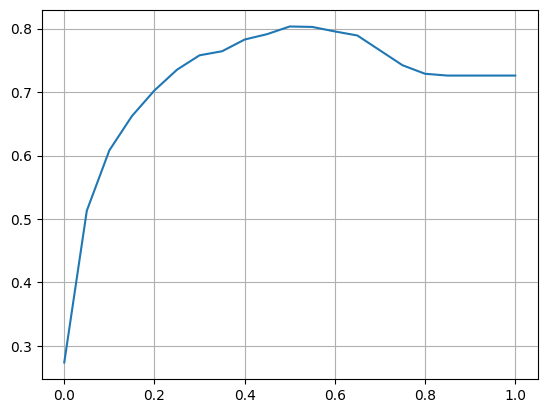

In [12]:
fix, ax = plt.subplots()
ax.plot(threshholds, scores)
ax.grid()

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [15]:
threshholds = np.linspace(0, 1, 21)
scores = []

for t in threshholds:
    score = accuracy_score(y_val, y_pred >= t)
    scores.append(score)
    print("%.2f  %.3f" % (t, score))

0.00  0.274
0.05  0.513
0.10  0.608
0.15  0.662
0.20  0.703
0.25  0.735
0.30  0.758
0.35  0.764
0.40  0.783
0.45  0.791
0.50  0.803
0.55  0.803
0.60  0.796
0.65  0.789
0.70  0.766
0.75  0.742
0.80  0.729
0.85  0.726
0.90  0.726
0.95  0.726
1.00  0.726


In [16]:
y_pred >= 1.0

array([False, False, False, ..., False, False, False])

In [17]:
from collections import Counter

In [18]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

Our Dummy model is 73% accurate

while our model is 80% accurate

In [19]:
y_val

array([0, 0, 0, ..., 0, 1, 1])

In [20]:
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

Class imbalance 3:1 ratio b/c there are three more times non-churning customers than churning

## 4.3 Confusion table

* Different types of errors and correct decisions
* Arranging them in a table
  

True positive - correct prediction of churn
True negative - correct prediction of no - churn

False positive = customer predicted to churn, but did not churn
False negative = customer predicted not to churn, but churned


In [21]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)


In [22]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [23]:
predict_positive[:5]

array([False, False, False,  True, False])

In [24]:
actual_positive[:5] #at 12:10 in video

array([False, False, False,  True, False])

In [25]:
tp = (predict_positive & actual_positive).sum() #element-vise logical AND
tn = (predict_negative & actual_negative).sum()
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [26]:
print(fp.sum())
print(fn.sum())

103
174


Predictions


In [27]:
confusion_matrix = np.array([[tn, fp],
                           [fn, tp]])
confusion_matrix

array([[920, 103],
       [174, 212]])

In [28]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

Accuracy = 80% = 65% + 15% 

## 4.4 Precision and Recall

In [29]:
(tp + tn)/(tp + tn + fp + fn)

np.float64(0.8034066713981547)

__Precision__ = what fraction of positive predictions are correct!

out of four people positively predicted - one was false positive therefore our precision is 3/4 = 75%

**Precision** 
$$Precision=TP/(TP+FP)$$

In [30]:
p = tp/(tp+fp)
print(f"Precision:{round(p, 2)}%")

Precision:0.67%


__RECALL__ - fraction of correctly identified positive examples

![Recall Chart](images/recall.png "a title")

**Recall** 
$$Recall=TP/(TP+FN)$$

In [31]:
r= tp/(tp+fn)
print(f"Recall:{round(r, 2)}%")


Recall:0.55%


__Accuracy 80%__ which seems high, but when we look at precision and recall - we failed to id 45% who are going to churn

_accuracy is misleading, especially when you have __class imbalance___


![Precision Recall Accuracy](images/precision_recall_accuracy.jpg "Precision Recall Accuracy")

## 4.5 ROC Curves
Receiving Operating Characteristics

(WWII for evaluating strength of radar)

FPR - false positive rate

TPR - true positive rate

$$ FPR = FP/(TN+FP)$$

$$TPR = TP/(FN+TP)$$

![ROC_1](images/roc_1.png "Precision Recall Accuracy")

#### Recall is the same as True positive rate (TPR)

In [32]:
tpr = tp/(tp+fn)
tpr

np.float64(0.5492227979274611)

In [33]:
fpr=fp/(fp+tn)
fpr

np.float64(0.10068426197458455)

Let's compute these values for all possible thresholds

In [34]:
thesholds = np.linspace(0, 1, 101)
len(thesholds)

101

In [35]:
scores = []

for t in thesholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum() #element-vise logical AND
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    scores.append((t, tp, fp, fn, tn))
len(scores)

101

In [36]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10] #this will return (display) every 10th record
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)


In [37]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,532,20,491,0.948187,0.520039
20,0.2,339,372,47,651,0.878238,0.363636
30,0.3,292,247,94,776,0.756477,0.241447
40,0.4,255,175,131,848,0.660622,0.171065
50,0.5,212,103,174,920,0.549223,0.100684
60,0.6,151,53,235,970,0.391192,0.051808
70,0.7,69,13,317,1010,0.178756,0.012708
80,0.8,4,0,382,1023,0.010363,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


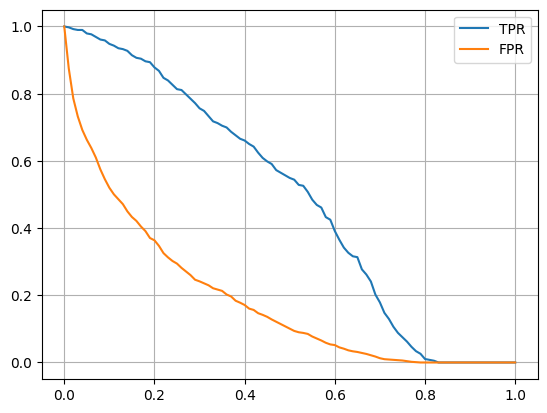

In [38]:
fix, ax = plt.subplots()
ax.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
ax.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
ax.grid()
ax.legend()

## Random model

In [39]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val)) #this creates another random prediction of the length same as our validaton array

In [40]:
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [41]:
((y_rand >=5) == y_val).mean() #accuracy for this model

np.float64(0.7260468417317246)

In [42]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    for t in thesholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        tp = (predict_positive & actual_positive).sum() #element-vise logical AND
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores[::10] #this will return (display) every 10th record
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    return df_scores

In [43]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [44]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


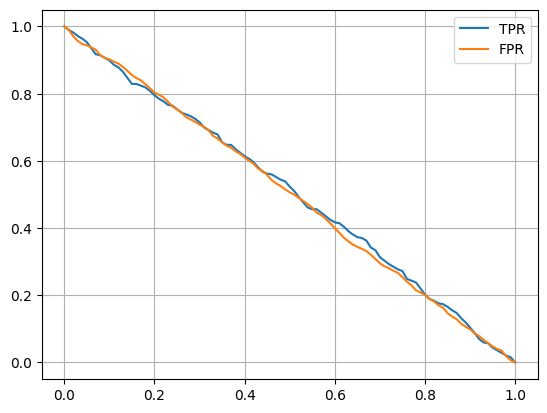

In [45]:
fix, ax = plt.subplots()
ax.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
ax.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
ax.grid()
ax.legend()

## Ideal model

need to come up with a model that gives us an ideal predictions

![Ideal model](images/ideal_model.png "Ideal model drawing")

In [46]:
num_neg = (y_val ==0).sum()
num_pos = (y_val ==1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [47]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [48]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [49]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [50]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

In [51]:
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


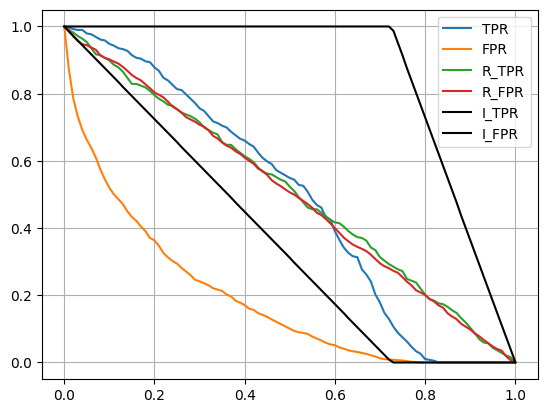

In [52]:
fix, ax = plt.subplots()

ax.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
ax.plot(df_scores.threshold, df_scores['fpr'], label='FPR')

ax.plot(df_rand.threshold, df_rand['tpr'], label='R_TPR')
ax.plot(df_rand.threshold, df_rand['fpr'], label='R_FPR')

ax.plot(df_ideal.threshold, df_ideal['tpr'], label='I_TPR', color='black')
ax.plot(df_ideal.threshold, df_ideal['fpr'], label='I_FPR', color='black')
ax.grid()
ax.legend()

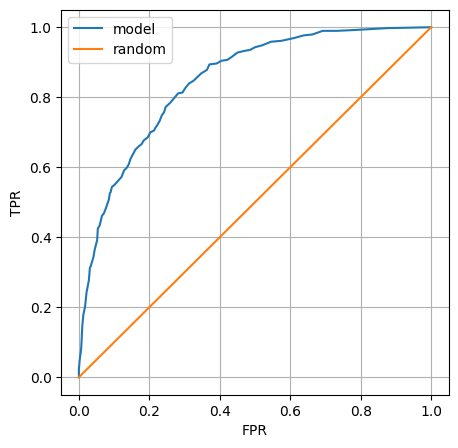

In [53]:

plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr,df_scores.tpr, label="model")
plt.plot([0,1], [0,1], label= 'random' )
#plt.plot(df_rand.fpr,df_rand.tpr, label="random")
#plt.plot(df_ideal.fpr,df_ideal.tpr, label="ideal")
# ax.plot(df_scores.threshold, df_scores['fpr'], label='FPR'



plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()

![Ideal model](images/ideal_model_graph.png "Ideal model drawing")

__Plotting the ROC with sklearn__

In [54]:
from sklearn.metrics import roc_curve

In [55]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

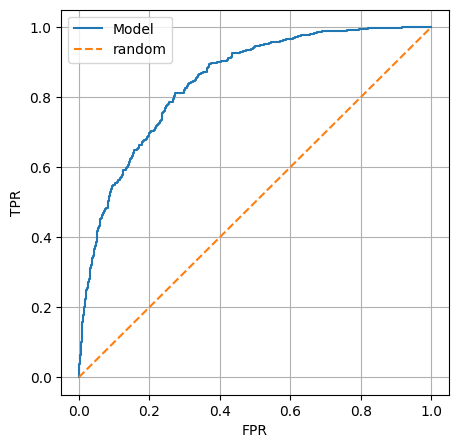

In [56]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label="Model")
plt.plot([0,1], [0,1], label= 'random', linestyle='--')

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()

## 4.6 ROC AUC -- Area under the curve

* Area under the ROC curve - useful metric
* Interpretation of AUC

In [57]:
from sklearn.metrics import auc

In [58]:
auc(fpr, tpr)

np.float64(0.8462968309199298)

In [59]:
auc(df_scores.fpr, df_scores.tpr)

np.float64(0.8461866703133627)

In [60]:
auc(df_ideal.fpr, df_ideal.tpr)

np.float64(0.9999430203759136)

In [61]:
fpr, tpr, threshholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

np.float64(0.8462968309199298)

even more siplified

In [62]:
from sklearn.metrics import roc_auc_score

In [63]:
roc_auc_score(y_val, y_pred)

np.float64(0.8462968309199298)

AUC = probability that randomly selected positive example (churn) has a higher score than randomly selected negative example (no-churn)

In [64]:
neg = y_pred[y_val ==0]
pos = y_pred[y_val == 1]


In [65]:
import random

In [66]:
pos_index = random.randint(0, len(pos)-1)
pos_index

32

In [67]:
neg_index = random.randint(0, len(neg)-1)
neg_index

188

In [68]:
n = 100000
success = 0
for i in range(n):
    pos_index = random.randint(0, len(pos)-1)
    neg_index = random.randint(0, len(neg)-1)
    if(pos[pos_index] > neg[neg_index]):
        success = success + 1
success/n

0.84453

In [69]:
n=10000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind]>neg[neg_ind]).mean()

np.float64(0.8459)

## 4.7 Cross-Validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

K-FOLD cross validation

In [70]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train=dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=5000)
    model.fit(X_train, y_train)
    return dv, model
    

In [71]:
dv, model = train(df_train, y_train, C=0.001)

In [72]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient = "records")
    X=dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred

In [73]:
y_pred = predict(df_val, dv, model)

In [74]:
from sklearn.model_selection import KFold

In [75]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [76]:
!pip install tqdm

In [77]:
from tqdm.auto import tqdm


In [78]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]): 

    scores = []
    
    kfold = KFold(n_splits, shuffle=True, random_state=1)

    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.churn.values
        y_val = df_val.churn.values
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.5f' % (C, np.mean(scores), np.std(scores)))


  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.00928
C=0.01 0.840 +- 0.00827
C=0.1 0.842 +- 0.00722
C=0.5 0.842 +- 0.00691
C=1 0.842 +- 0.00684
C=5 0.842 +- 0.00686
C=10 0.842 +- 0.00682


Now we need to train our FINAL model on the full train dataset and evaluate on test dataset

In [79]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

np.float64(0.8584005005037537)

## 4.8 Summary

* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading (with class imbalance)
* Precision and recall are less misleading when we ahve class imbalance
* ROC Curve - a way to evaluate the performance at all thresholds; OK to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + sdt)